In [19]:
import numpy as np
import sys 
sys.path.append(r'../../Python Script/')

from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from xLSINDy import *
from sympy.physics.mechanics import *
from sympy import *
import sympy
import torch
import HLsearch as HL
import matplotlib.pyplot as plt

In [51]:
#Saving Directory
rootdir = "../../Single Pendulum/"

num_sample = 1
create_data = False
training = False

a = 1
b = 1
noiselevel = a*10**(-b)

In [52]:
states_dim = 2
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

states are: (x0, x0_t)
states derivatives are:  (x0_t, x0_tt)


In [53]:
#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

In [54]:

#identifier = "no"
identifier = str(a) + "e-0" + str(b)
if(training==False):
    with open(rootdir + "Data/Active/lagrangian_" + identifier + "_noise.txt") as f:
        L = f.readline()
        print(L)
        expr = L.split(" +")
        device = "cuda:0"
        xi_L = torch.ones(len(expr),device=device)
        mask = torch.ones(len(expr),device=device)

0.36*x0_t**2 + 7.19*cos(x0)


In [55]:
#for lagrangian
x0 = dynamicsymbols(states[0], real=True)
x0_t = dynamicsymbols(states[0],1, real=True)
T = symbols('T')

#True Lagrangian
L = eval(str(L))

# Lagrange's method
LM = LagrangesMethod(L, [x0])
LM.form_lagranges_equations()
i_forcing = LM.forcing #internal forcing and gravity
e_forcing = sympy.Matrix([T]) #external generalized force

In [56]:
# Substituting dynamic symbols

i_forcing = i_forcing.subs(x0_t, states_sym[1])
i_forcing = i_forcing.subs(x0, states_sym[0])

M = LM.mass_matrix
M = M.subs(x0, states_sym[0])

In [57]:
# Generating equation of motion
t_forcing = i_forcing + e_forcing
eom = M.inv()*sympy.Matrix(t_forcing)

In [58]:
''' Please copy the string shown to the definition of equation in the function of double pendulum'''
for i in range(len(eom)):
    print('Equation ' + str(i) +': ' + str(eom[i]))
    print('\n')

Equation 0: 1.38888888888889*T - 9.98611111111111*sin(x0)




In [59]:
import time

g = 9.81
m = 1
L,l = 1,1


def torque(t,omega):
    return 2*np.cos(omega*t)


def predictedsinglePendulum(t,y, omega):
    from numpy import sin, cos, sign
    x0,x0_t = y
    T = torque(t, omega)
    x0_tt = eval(str(eom[0]))
    return x0_t, x0_tt

def singlePendulum(t,y, omega):
    from numpy import sin, cos, sign
    x0,x0_t = y
    T = torque(t, omega)
    x0_tt = -1.0*g*sin(x0)/L + 1.0*T/(L**2*m)
    return x0_t, x0_tt


def generate_data(func, time, init_values, omega):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='LSODA', rtol=1e-10,atol=1e-10, args=[omega])
    return sol.y.T, np.array([func(time[i],sol.y.T[i,:], omega = omega) for i in range(sol.y.T.shape[0])],dtype=np.float64)

In [60]:
## SINDy-PI ##

'''file name : Double Pendulum/Data/SINDy-PI_2e-02_noise.txt'''

def SINDyPI(t,y):
    from numpy import sin, cos
    z1,z2,z3,z4 = y
    dz1=1.0*z3
    dz2=z4
    dz3=(2.292e+7*sin(2.0*z1 - 2.0*z2) - 2.093e+7*sin(2.0*z1 - 1.0*z2) + 2.005e+7*sin(z1 - z2) + 1.238e+7*sin(z1 - 2.0*z2) + 7.062e+7*sin(z1) - 5.678e+6*sin(z2) + 1.477e+6*z3**2*sin(2.0*z1 - 1.0*z2) + 1.06e+6*z4**2*sin(2.0*z1 - 1.0*z2) - 1.609e+6*z4**2*sin(2.0*z1 - 2.0*z2) - 1.887e+6*z3**2*sin(z1 - z2) + 3.678e+6*z4**2*sin(z1 - z2) + 1.541e+6*z3**2*sin(z1 - 2.0*z2) + 9.951e+5*z4**2*sin(z1 - 2.0*z2))/(6.543e+6*cos(z1 - 1.0*z2)**2 - 1.0e+7)
    dz4=-(1.0*(8.16*sin(2.0*z1 - 1.0*z2) + 3.179*sin(2.0*z1 - 2.0*z2) - 2.906*sin(z1 - z2) + 1.408*sin(z1) - 9.208*sin(z2) + 0.8598*z3**2*sin(z1 - z2)))/(cos(z1 - 1.0*z2)**2 - 1.307)
    return dz1, dz2, dz3, dz4

In [61]:
## Training Results ##
import matplotlib.pyplot as plt

t = np.arange(0,10,0.01)
theta = 0.2482306625459123
thetadot = -1.3203817110229212
cond = 0.5*thetadot**2 - np.cos(theta)
#checking condition so that it does not go full loop
while(cond>0.99):
    theta = np.random.uniform(-np.pi, np.pi)
    thetadot = np.random.uniform(-2.1,2.1)
    cond = 0.5*thetadot**2 - np.cos(theta)
omega = 2.537685907969456


y0 = np.array([theta, thetadot])
tau = torque(t, omega) 

#true value
X,Xdot = generate_data(singlePendulum,t,y0,omega=omega)



q_tt_true_wn = (Xdot[:,states_dim//2:].T).copy()
q_t_true_wn = (Xdot[:,:states_dim//2].T).copy()
q_true_wn = (X[:,:states_dim//2].T).copy()

#adding noise
mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
noise[500:] = 0
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise

q_tt_true = Xdot[:,states_dim//2:].T
q_t_true = Xdot[:,:states_dim//2].T
q_true = X[:,:states_dim//2].T

#xL-SINDy (active)
Xpred, Xdotpred = generate_data(predictedsinglePendulum,t,y0,omega=omega)

q_tt_pred = Xdotpred[:,states_dim//2:].T
q_t_pred = Xdotpred[:,:states_dim//2].T
q_pred = Xpred[:,:states_dim//2].T

# #SINDy PI
# Xspi, Xdotspi = generate_data(SINDyPI, t, y_0) 

# q_tt_spi = Xdotspi[:,states_dim//2:].T
# q_t_spi = Xdotspi[:,:states_dim//2].T
# q_spi = Xspi[:,:states_dim//2].T

In [62]:
## Test Results ##
# ttest = np.arange(5,10,0.01)
# y_0 = np.array([q_true_wn[0,-1], q_true_wn[1,-1], q_t_true_wn[0,-1], q_t_true_wn[1,-1]])
# Xtest,Xdottest = generate_data(doublePendulum, ttest, y_0)

# y_0 = np.array([q_pred[0,-1], q_pred[1,-1], q_t_pred[0,-1], q_t_pred[1,-1]])
# Xtestpred,Xdottestpred = generate_data(predicteddoublependulum, ttest, y_0)

# # y_0 = np.array([q_spi[0,-1], q_spi[1,-1], q_t_spi[0,-1], q_t_spi[1,-1]])
# # Xtestspi,Xdottestspi = generate_data(SINDyPI, ttest, y_0)

In [63]:
# Concatenante training and test data
# t = np.concatenate((t, ttest))
# q_tt_true = np.concatenate((q_tt_true, Xdottest[:,states_dim//2:].T), axis=1)
# q_t_true = np.concatenate((q_t_true, Xtest[:,states_dim//2:].T), axis=1)
# q_true = np.concatenate((q_true,Xtest[:,:states_dim//2].T), axis=1)

# q_tt_pred = np.concatenate((q_tt_pred,Xdottestpred[:,states_dim//2:].T), axis=1)
# q_t_pred = np.concatenate((q_t_pred, Xtestpred[:,states_dim//2:].T), axis=1)
# q_pred = np.concatenate((q_pred,Xtestpred[:,:states_dim//2].T), axis=1)

# q_tt_spi = np.concatenate((q_tt_spi,Xdottestspi[:,states_dim//2:].T), axis=1)
# q_t_spi = np.concatenate((q_t_spi, Xtestspi[:,states_dim//2:].T), axis=1)
# q_spi = np.concatenate((q_spi,Xtestspi[:,:states_dim//2].T), axis=1)

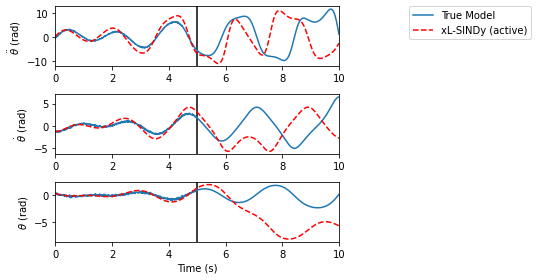

In [64]:
fig, ax = plt.subplots(3,1,figsize=(5,4))

ax[0].plot(t, q_tt_true[0,:], label='True Model')
ax[0].plot(t, q_tt_pred[0,:], 'r--',label='xL-SINDy (active)')
ax[0].set_ylabel('$\ddot{\\theta}$ (rad)')
ax[0].vlines(5,0,1,transform=ax[0].get_xaxis_transform(),colors='k')
ax[0].set_xlim([0,10])

ax[1].plot(t, q_t_true[0,:], label='True Model')
ax[1].plot(t, q_t_pred[0,:], 'r--',label='xL-SINDy (active)')
ax[1].set_ylabel('$\dot{\\theta}$ (rad)')
ax[1].vlines(5,0,1,transform=ax[1].get_xaxis_transform(),colors='k')
ax[1].set_xlim([0,10])

ax[2].plot(t, q_true[0,:], label='True Model')
ax[2].plot(t, q_pred[0,:], 'r--',label='xL-SINDy (active)')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('$\\theta$ (rad)')
ax[2].vlines(5,0,1,transform=ax[2].get_xaxis_transform(),colors='k')
ax[2].set_xlim([0,10])

Line, Label = ax[0].get_legend_handles_labels()
fig.legend(Line, Label, loc='upper right', bbox_to_anchor=(1.5, 0.98))

fig.tight_layout()
fig.savefig(rootdir + "Images/Active/training_" + identifier+ "_noise.png", bbox_inches='tight',dpi=400)


In [65]:
np.save(rootdir + "Data/Active/q_pred_" + identifier + "_noise.png", q_pred)
np.save(rootdir + "Data/Active/q_true", q_true)